In [5]:
import os
import pickle as pkl
from BirdSongToolbox.import_data import ImportData
from config import path_to_save,spectrogram_specs
import librosa, librosa.display
import numpy as np
import matplotlib.pyplot as plt

# Zebra Finch Recording Details
z007 - day-2016-09-09/10/11/13 <br>
z017 - day-2016-06-19/21 <br>
z020 - day-2016-06-03/05

In [6]:
path_to_data = "/home/debrown/Chunk_Data_Temp/"

bird_id = os.listdir(path_to_data)
print("Birds:",bird_id)

days = []
for i in bird_id:
    recordings = os.listdir(path_to_data+i)
    days.append(recordings)
print("Recording dates:",days)
    
pkl.dump([bird_id,days],open(path_to_save+"zf_recordings.pkl","wb"))


Birds: ['z007', 'z017', 'z020']
Recording dates: [['day-2016-09-09', 'day-2016-09-10', 'day-2016-09-11', 'day-2016-09-13'], ['day-2016-06-21', 'day-2016-06-19'], ['day-2016-06-05', 'day-2016-06-03']]


# Load config file

In [7]:
bird_id, days = pkl.load(open(path_to_save+"zf_recordings.pkl","rb"))
num_birds = len(bird_id)
print(num_birds)

#spectrogram specifications
sr = spectrogram_specs["sr"]
n_fft = spectrogram_specs["n_fft"]
window = spectrogram_specs["window"]
stride = spectrogram_specs["stride"]
fft_center = spectrogram_specs["fft_center"]
window_type = spectrogram_specs["window_type"]
if fft_center:
    pad = window/2
else:
    pad = 0
    
n_mels = spectrogram_specs["n_mels"]


#chunked audio is already band pass filtered between 300 - 10000 Hz
freq_res = (sr/2)/(1+n_fft/2)
print("Frequency resolution:",freq_res)
low_freq_ind = int(300/freq_res)
print("300Hz index in spectrogram:",low_freq_ind)
high_freq_ind = int(10000/freq_res)+1
print("10000Hz index in spectrogram:",high_freq_ind)
    

3
Frequency resolution: 116.27906976744185
300Hz index in spectrogram: 2
10000Hz index in spectrogram: 87


# Generate spectrograms and labels

In [8]:
for bird_ind in range(num_birds):
    for rec_ind in range(len(days[bird_ind])):
        print("\nBird:",bird_id[bird_ind],"Day:",days[bird_ind][rec_ind])
        data=ImportData(bird_id=bird_id[bird_ind], session=days[bird_ind][rec_ind])#,location = get_spec_config_path("Chunked_Data_Path"))
        audio=data.song_audio
        hand_labels=data.song_handlabels
        print("No. of chunks = ",len(audio))
#         print("Motifs in chunked audio data = ",data.song_ledger)
        
        #variables to store all chunked data in a day
        spectrograms = []
        mel_spectrograms = []
        labels = [[]] * len(audio)
        
        for chunk_ind in range(len(audio)):
            print("-----Processing chunk ",chunk_ind+1,'-----')
            
            #COMPUTE BUFFER LENGTH
            #-----------------------------------------------------------------------------------------
            #buffer length
            start_buffer = hand_labels[chunk_ind]["labels"][1][1][0]
            end_buffer = hand_labels[chunk_ind]["labels"][1][1][-1] - hand_labels[chunk_ind]["labels"][1][0][-1] 
#             print("Front buffer length:",start_buffer)
#             print("Terminal buffer length:",end_buffer)
            print("Buffer free audio length:",len(audio[chunk_ind])-start_buffer-end_buffer)

            if ~fft_center:
                start_buffer = int((start_buffer - window) / stride) + 1
                end_buffer = int((end_buffer - window) / stride) + 1
            #-----------------------------------------------------------------------------------------

            
            #COMPUTE SPECTROGRAM
            #-----------------------------------------------------------------------------------------
            #spectrogram
            S_amp=librosa.stft(audio[chunk_ind],n_fft=n_fft,hop_length=stride,win_length=window,window=window_type,center=fft_center)
            S_pow = np.abs(S_amp)**2

#             print("Original spectrogram shape:",np.shape(S_pow))
            if fft_center:
                S_pow = S_pow[:,start_buffer:(np.shape(S_pow)[1] - end_buffer -1)] #removing buffer from spectrogram
            else:
                S_pow = S_pow[:,start_buffer:(np.shape(S_pow)[1] - end_buffer)] #removing buffer from spectrogram

           
            #band pass filtering the spectrogram from 300 - 10000 Hz and storing the data
            spectrograms.append(S_pow[low_freq_ind:high_freq_ind,:])
            mel_spectrograms.append(librosa.feature.melspectrogram(S=S_pow,sr=sr,n_mels = n_mels,fmin=300,fmax=10000))
            print("Buffer free spectrogram shape:",np.shape(S_pow))
            #-----------------------------------------------------------------------------------------
            
            
            #TRANSLATE TIME FROM RECORDING SPACE TO SPECTROGRAM SPACE
            #-----------------------------------------------------------------------------------------
            #translating time
            lbl = hand_labels[chunk_ind]['labels'][0]
            lbl = lbl[1:-1] #remove buffer from lbl
            print("Labels:",lbl)
            time = hand_labels[chunk_ind]['labels'][1]
            
            shifted_time = [[],[]]
            shifted_time[0] = [int((time[0][k] - window + (2*pad))/stride)+1 for k in range(1,len(time[0]))]
            shifted_time[0].insert(0,0)
            shifted_time[1] = [int((time[1][k] - window + (2*pad))/stride)+1 for k in range(0,len(time[1]))]
#             print(shifted_time[0])
#             print(shifted_time[1])
#             print("Shifted time length:",shifted_time[1][-1])
            
            shifted_time[0] = [k - shifted_time[1][0] for k in shifted_time[0]]
            shifted_time[1] = [k -shifted_time[1][0] for k in shifted_time[1]]
            shifted_time[0] = shifted_time[0][1:-1]
            shifted_time[1] = shifted_time[1][1:-1]
#             print(shifted_time[0])
#             print(shifted_time[1])
#             print("Buffer free shifted time length:",shifted_time[1][-1])
 
            #correcting translated time length (due to rounding error while shifting time)
            if shifted_time[1][-1]!=np.shape(S_pow)[1]:
                shifted_time[1][-1]=np.shape(S_pow)[1]
            print("Corrected buffer free shifted time length:",shifted_time[1][-1])
            #-----------------------------------------------------------------------------------------
            
           
            #PROCESS LABELS AND STORE THEM ALONG WITH TIME STAMP
            #-----------------------------------------------------------------------------------------
            #frame level labels
            frame_labels = ['X']*shifted_time[1][-1]
            for j in range(len(lbl)):
                frame_labels[shifted_time[0][j]:shifted_time[1][j]] = [lbl[j]] * (shifted_time[1][j]-shifted_time[0][j]) 

            print("Label length:",len(frame_labels))
#             print("Unique labels:",np.unique(frame_labels))
#             print("No. of X:",frame_labels.count('X'))
#             print("Indices of X:",[ind for ind,val in enumerate(frame_labels) if val=='X'])

            #binarizing labels
            bin_labels = [0 if k in [8,'C','I','X'] else 1 for k in frame_labels]

            #net labels
            labels[chunk_ind] = {"labels":lbl,"time":shifted_time,"frame_labels":frame_labels,
                                        "binary_labels":bin_labels}
            #-----------------------------------------------------------------------------------------
            
            #CHECK DIMENSIONS
            #-----------------------------------------------------------------------------------------
            if np.shape(S_pow)[1] != len(frame_labels) or np.shape(S_pow)[1] != shifted_time[1][-1]:
                print("MISMATCH!!! spec and label length mismatch; bird,day and chunk:",
                      bird_ind,rec_ind,chunk_ind)
            
            #-----------------------------------------------------------------------------------------
                
            
        
        #saving data
        dirName = path_to_save+"spectrograms"
        if not os.path.exists(dirName):
            os.mkdir(dirName)

        dirName = dirName+"/"+bird_id[bird_ind]
        if not os.path.exists(dirName):
            os.mkdir(dirName)

        dirName = dirName+"/"+days[bird_ind][rec_ind]
        if not os.path.exists(dirName):
            os.mkdir(dirName)
            
        pkl.dump(spectrograms,open(dirName+"/spectrograms.pkl","wb"))
        pkl.dump(mel_spectrograms,open(dirName+"/mel_spectrograms.pkl","wb"))
        pkl.dump(labels,open(dirName+"/labels.pkl","wb"))
    
            


Bird: z007 Day: day-2016-09-09
No. of chunks =  5
-----Processing chunk  1 -----
Buffer free audio length: 965505
Buffer free spectrogram shape: (129, 15093)
Labels: [8, 'I', 8, 'I', 8, 'I', 8, 'I', 8, 'I', 8, 1, 7, 2, 7, 3, 7, 4, 7, 5, 7, 6, 7, 1, 7, 2, 7, 3, 7, 4, 7, 5, 7, 1, 7, 2, 7, 3, 7, 4, 7, 5, 8, 'C', 8, 'C', 8, 'C', 8, 'I', 8, 'I', 8, 'I', 8, 1, 7, 2, 7, 3, 7, 4, 7, 5, 7, 1, 7, 2, 7, 3, 7, 4, 7, 5, 7, 1, 7, 2, 7, 3, 7, 4, 7, 5, 8, 'I', 8, 'I', 8, 'I', 8, 1, 7, 2, 7, 3, 7, 4, 7, 5, 7, 1, 7, 2, 7, 3, 7, 4, 7, 5, 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8]
Corrected buffer free shifted time length: 15093
Label length: 15093
-----Processing chunk  2 -----
Buffer free audio length: 1223879
Buffer free spectrogram shape: (129, 19130)
Labels: [8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'I', 8, '

Buffer free spectrogram shape: (129, 20871)
Labels: [8, 'C', 8, 'C', 8, 'C', 8, 'I', 8, 'I', 8, 'I', 8, 'C', 8, 'I', 8, 'I', 8, 'I', 8, 1, 7, 2, 7, 3, 7, 4, 7, 5, 7, 1, 7, 2, 7, 3, 7, 4, 7, 5, 7, 1, 7, 2, 7, 3, 7, 4, 7, 5, 8, 'C', 8, 'I', 8, 'I', 8, 'C', 8, 'I', 8, 1, 2, 7, 3, 7, 4, 7, 5, 7, 1, 7, 2, 7, 3, 7, 4, 7, 5, 8, 'C', 8]
Corrected buffer free shifted time length: 20871
Label length: 20871
-----Processing chunk  14 -----
Buffer free audio length: 1394586
Buffer free spectrogram shape: (129, 21797)
Labels: [8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'I', 8, 'I', 8, 'C', 8, 'I', 8, 'I', 8, 'C', 8, 'I', 8, 1, 7, 2, 7, 3, 7, 4, 7, 5, 7, 1, 7, 2, 7, 3, 7, 4, 7, 5, 7, 1, 7, 2, 7, 3, 7, 4, 7, 5, 8, 'I', 8, 'I', 8, 'I', 8, 1, 7, 2, 7, 3, 7, 4, 7, 5, 7, 1, 7, 2, 7, 3, 7, 4, 7, 5, 8, 'I', 8, 'I', 8, 'I', 8, 1, 7, 2, 7, 3, 7, 4, 7, 5, 7, 1, 7, 2, 7, 3, 7, 4, 7, 5, 8, 'C', 8]
Corrected buffer free shifted time length: 21797
Label length: 21797

Bird: z007 Day: day-2016-09-11
No. of chunks =  20
---

Buffer free spectrogram shape: (129, 19862)
Labels: [8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'I', 8, 'I', 8, 'C', 8, 'I', 8, 'I', 8, 'C', 8, 'I', 8, 1, 7, 2, 7, 3, 7, 4, 7, 5, 7, 1, 7, 2, 7, 3, 7, 4, 7, 5, 7, 1, 7, 2, 7, 3, 7, 4, 7, 5, 7, 1, 7, 2, 7, 3, 7, 4, 7, 5, 8, 'C', 8, 'C', 8]
Corrected buffer free shifted time length: 19862
Label length: 19862
-----Processing chunk  17 -----
Buffer free audio length: 1338186
Buffer free spectrogram shape: (129, 20916)
Labels: [8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'I', 8, 'I', 8, 'I', 8, 'I', 8, 'I', 8, 'I', 8, 'I', 8, 1, 7, 2, 7, 3, 7, 4, 7, 5, 7, 1, 7, 2, 7, 3, 7, 4, 7, 5, 7, 1, 7, 2, 7, 3, 7, 4, 7, 5, 8, 'I', 8, 'I', 8, 1, 7, 2, 7, 3, 7, 4, 7, 5, 7, 1, 7, 2, 7, 3, 7, 4, 7, 5, 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8]
Corrected buffer free shifted time length: 20916
Label length: 20916
-----Processing chunk  18 -----
Buffer free audio length: 1347542
Buffer free spectrogram shape: (129, 21062)
Labels: 

Buffer free spectrogram shape: (129, 18757)
Labels: [8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 1, 9, 2, 9, 3, 9, 4, 9, 5, 9, 6, 9, 7, 9, 1, 9, 2, 9, 3, 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8]
Corrected buffer free shifted time length: 18757
Label length: 18757
-----Processing chunk  8 -----
Buffer free audio length: 1442057
Buffer free spectrogram shape: (129, 22539)
Labels: [8, 'C', 8, 'C', 8, 1, 9, 2, 9, 3, 9, 4, 9, 5, 9, 6, 9, 7, 9, 1, 9, 2, 9, 3, 9, 4, 9, 5, 9, 6, 9, 7, 9, 1, 9, 2, 9, 3, 9, 4, 9, 5, 9, 6, 9, 7, 9, 1, 9, 2, 9, 3, 9, 4, 9, 5, 8, 1, 9, 2, 9, 3, 9, 4, 9, 5, 9, 6, 9, 7, 9, 1, 9, 2, 9, 3, 9, 4, 9, 5, 9, 6, 8, 1, 9, 2, 9, 3, 9, 4, 9, 5, 9, 6, 8]
Corrected buffer free shifted time length: 22539
Label length: 22539
-----Processing chunk  9 -----
Buffer free audio length: 1639834
Buffer free spectrogram shape: (129, 25629)
Labels: [8, 'C', 8, 'C', 8, 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 1, 9, 2, 9, 3, 

Buffer free spectrogram shape: (129, 19199)
Labels: [8, 1, 9, 2, 9, 3, 9, 4, 9, 5, 9, 6, 9, 7, 9, 1, 9, 2, 9, 3, 9, 4, 9, 5, 9, 6, 8]
Corrected buffer free shifted time length: 19199
Label length: 19199
-----Processing chunk  11 -----
Buffer free audio length: 1257371
Buffer free spectrogram shape: (129, 19653)
Labels: [8, 1, 9, 2, 9, 3, 9, 4, 9, 5, 9, 6, 9, 7, 9, 1, 9, 2, 9, 3, 9, 4, 9, 5, 9, 6, 9, 7, 9, 1, 9, 2, 9, 3, 9, 4, 9, 5, 8]
Corrected buffer free shifted time length: 19653
Label length: 19653
-----Processing chunk  12 -----
Buffer free audio length: 1256877
Buffer free spectrogram shape: (129, 19645)
Labels: [8, 1, 9, 2, 9, 3, 9, 4, 9, 5, 9, 6, 9, 7, 9, 1, 9, 2, 9, 3, 9, 4, 9, 5, 9, 6, 9, 7, 9, 1, 9, 2, 9, 3, 9, 4, 9, 5, 9, 6, 8]
Corrected buffer free shifted time length: 19645
Label length: 19645
-----Processing chunk  13 -----
Buffer free audio length: 1256961
Buffer free spectrogram shape: (129, 19647)
Labels: [8, 1, 9, 2, 9, 3, 9, 4, 9, 5, 9, 6, 9, 7, 9, 1, 9, 2, 9, 3, 9,

Buffer free spectrogram shape: (129, 28673)
Labels: [8, 'C', 8, 'I', 8, 'I', 8, 'I', 8, 'I', 8, 'I', 8, 1, 8, 2, 7, 3, 7, 4, 7, 1, 7, 2, 7, 3, 7, 4, 7, 1, 7, 2, 7, 3, 8, 'I', 8, 'I', 8, 1, 7, 2, 7, 3, 7, 4, 7, 1, 7, 2, 7, 3, 8, 'I', 8, 'C', 8, 'I', 8, 'I', 8, 'I', 8, 'I', 8, 'I', 8, 'I', 8, 1, 7, 2, 7, 3, 7, 4, 7, 1, 7, 2, 7, 3, 7, 4, 7, 1, 7, 2, 7, 3, 8, 'I', 8, 1, 7, 2, 7, 3, 8]
Corrected buffer free shifted time length: 28673
Label length: 28673
-----Processing chunk  14 -----
Buffer free audio length: 1229697
Buffer free spectrogram shape: (129, 19221)
Labels: [8, 'C', 8, 'I', 8, 'C', 8, 'I', 8, 'I', 8, 'I', 8, 'I', 8, 'I', 8, 1, 7, 2, 7, 3, 7, 4, 7, 1, 7, 2, 7, 3, 7, 4, 7, 1, 7, 2, 7, 3, 8, 'C', 8, 'I']
Corrected buffer free shifted time length: 19221
Label length: 19221
-----Processing chunk  15 -----
Buffer free audio length: 1848627
Buffer free spectrogram shape: (129, 28891)
Labels: ['I', 8, 'I', 8, 'I', 8, 'I', 8, 'I', 8, 'I', 8, 'I', 8, 'I', 8, 'I', 8, 'I', 8, 1, 7, 2, 7, 3,

Buffer free spectrogram shape: (129, 20384)
Labels: [8, 'C', 8, 'C', 8, 'C', 8, 'I', 8, 'I', 8, 'I', 8, 'I', 8, 'I', 8, 'I', 8, 1, 7, 2, 7, 3, 7, 4, 7, 1, 7, 2, 7, 3, 7, 4, 7, 1, 7, 2, 7, 3, 7, 4, 7, 1, 7, 2, 7, 3, 7, 4, 7, 1, 7, 2, 7, 3, 7, 1, 7, 2, 7, 3, 8, 'I', 7, 1, 7, 2, 7, 3, 7, 4, 7, 1, 7, 2, 7, 3, 8, 'C', 8]
Corrected buffer free shifted time length: 20384
Label length: 20384
-----Processing chunk  17 -----
Buffer free audio length: 1293555
Buffer free spectrogram shape: (129, 20218)
Labels: [8, 'I', 8, 'I', 8, 'I', 8, 'I', 8, 'I', 8, 'I', 8, 'I', 8, 'I', 8, 1, 7, 2, 7, 3, 7, 4, 7, 1, 7, 2, 7, 3, 7, 4, 7, 1, 7, 2, 7, 3, 7, 4, 7, 1, 7, 2, 7, 3, 7, 4, 7, 1, 7, 2, 7, 3, 8, 'I', 8, 1, 7, 2, 7, 3, 7, 4, 7, 1, 7, 2, 7, 3, 8]
Corrected buffer free shifted time length: 20218
Label length: 20218
-----Processing chunk  18 -----
Buffer free audio length: 1315496
Buffer free spectrogram shape: (129, 20561)
Labels: [8, 'C', 8, 'C', 8, 'I', 8, 'I', 8, 'I', 8, 'I', 8, 'I', 8, 'I', 8, 1, 7, 2,

# Visualization
### Note: The default setting for Y-axis is shown below. However, the spectrogram has been band pass filtered from 300-10000Hz. Therefore, the Y-axis is incorrectly depicted.

[8, 'I', 8, 'I', 8, 'I', 8, 'I', 8, 'I', 8, 1, 7, 2, 7, 3, 7, 4, 7, 5, 7, 6, 7, 1, 7, 2, 7, 3, 7, 4, 7, 5, 7, 1, 7, 2, 7, 3, 7, 4, 7, 5, 8, 'C', 8, 'C', 8, 'C', 8, 'I', 8, 'I', 8, 'I', 8, 1, 7, 2, 7, 3, 7, 4, 7, 5, 7, 1, 7, 2, 7, 3, 7, 4, 7, 5, 7, 1, 7, 2, 7, 3, 7, 4, 7, 5, 8, 'I', 8, 'I', 8, 'I', 8, 1, 7, 2, 7, 3, 7, 4, 7, 5, 7, 1, 7, 2, 7, 3, 7, 4, 7, 5, 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8, 'C', 8]


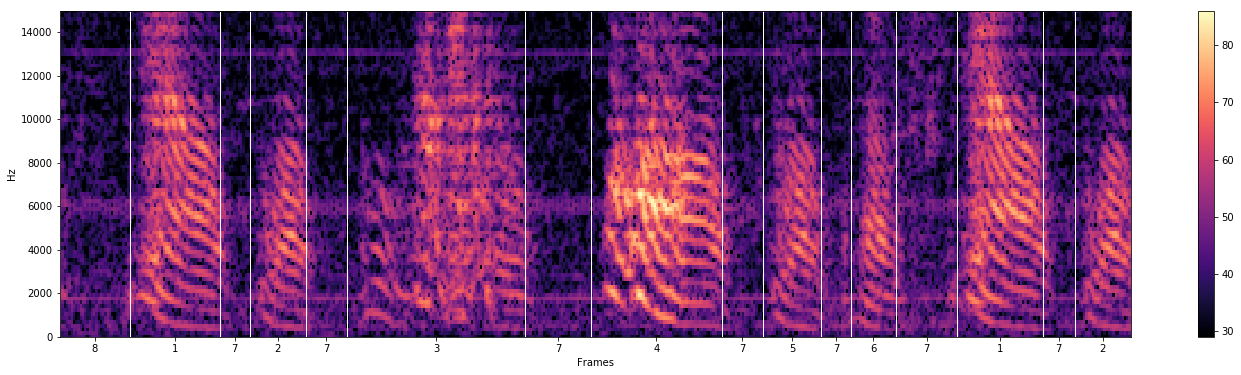

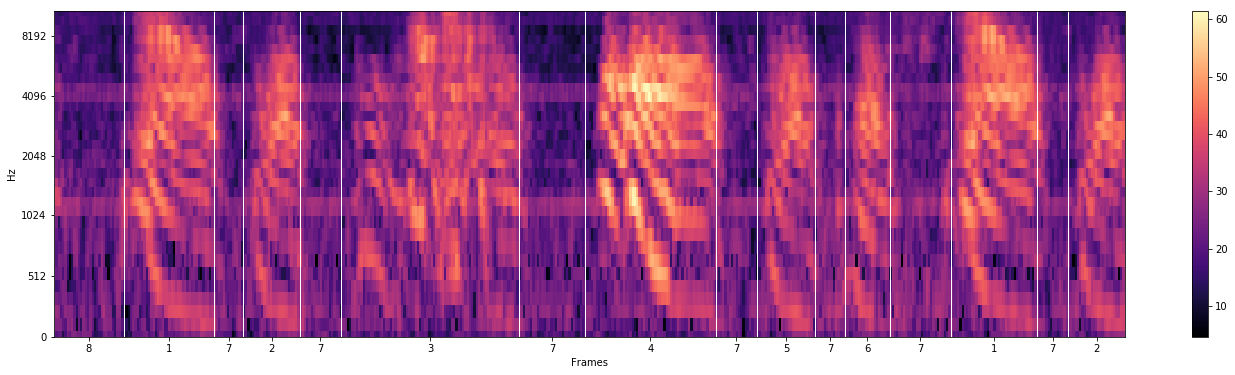

In [9]:
bird_ind = 0 #z007
rec_ind = 0 #day-2016-09-09
dirName = path_to_save+"spectrograms/"+bird_id[bird_ind]+'/'+days[bird_ind][rec_ind]
spectrograms = pkl.load(open(dirName+"/spectrograms.pkl","rb"))
mel_spectrograms = pkl.load(open(dirName+"/mel_spectrograms.pkl","rb"))
labels = pkl.load(open(dirName+"/labels.pkl","rb"))

for i in [0]:#range(len(spectrograms)):
    
    print(labels[i]["labels"])
    #choose a motif to display
    start_ind = 10
    end_ind = 25
    
    #spectrogram
    #------------------------------------------------------------------------------
    plt.figure(figsize=(24,6))
    
    #choose the chunk of spectrogram and convert to db
#     S_pow = spectrograms[i][:,labels[i][1][0][start_ind]:labels[i][1][1][end_ind]]
#     S_db = librosa.amplitude_to_db(S_pow)
    
    #convert the entire spectrogram to db and choose the chunk
    S_db = librosa.power_to_db(spectrograms[i])
    S_db = S_db[:,labels[i]["time"][0][start_ind]:labels[i]["time"][1][end_ind]]
    
    
    librosa.display.specshow(S_db,y_axis="linear",x_axis="frames",sr=sr,hop_length=stride) #display x-axis frames
    
    #plot vlines and xticks
    vline_ticks = [(k-labels[i]["time"][0][start_ind]) for k in labels[i]["time"][1][start_ind:end_ind+1]] #have to translate for x-axis as time
    vline_ticks.insert(0,0)
    x_ticks = [vline_ticks[k-1]+(vline_ticks[k]-vline_ticks[k-1])/2 for k in range(1,len(vline_ticks))]
    plt.vlines(vline_ticks,1,sr/2,colors='w', linewidth=1)
    plt.xticks(x_ticks,labels[i]["labels"][start_ind:start_ind+len(vline_ticks)+1])
    
    #plot frame level labels
#     frame_lbl_ind = labels[i][0][labels[i][1][0][start_ind]:labels[i][1][1][end_ind]]
#     plt.xticks(np.arange(np.shape(S_db)[1]),frame_lbl_ind)
    
    plt.colorbar()
#     plt.clim(80,200) 

    #mel spectrogram
    #------------------------------------------------------------------------------
    
    plt.figure(figsize=(24,6))
    
    #choose the chunk of spectrogram and convert to db
#     S_pow = mel_spectrograms[i][:,labels[i][1][0][start_ind]:labels[i][1][1][end_ind]]
#     S_db = librosa.power_to_db(S_pow)
    
    #convert the entire spectrogram to db and choose the chunk
    S_db = librosa.power_to_db(mel_spectrograms[i])
    S_db = S_db[:,labels[i]["time"][0][start_ind]:labels[i]["time"][1][end_ind]]
    
    librosa.display.specshow(S_db,y_axis="mel",x_axis="frames",sr=sr,hop_length=stride) #display x-axis frames
    plt.vlines(vline_ticks,1,sr/2,colors='w', linewidth=1)
    plt.xticks(x_ticks,labels[i]["labels"][start_ind:start_ind+len(vline_ticks)+1])
    plt.colorbar()